# Wine Dataset Analysis
By Rohit Satish (rsatish2)

This notebook will explore the [UCI Wine Dataset](https://archive.ics.uci.edu/ml/datasets/wine). This data set captures chemical measurements in wines that are derived from three cultivars in Italy fromt he same region too. In my project I want to understand how the chemcial profile distinguishes wine classes and builds interpretable models that can help discriminate between them. I use common data analysis tecniques here to go through and understand tis set and de3rive insightsd from it.

#1) Setup

The first thing we need to do is import the python packages we will need for the future

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

sns.set_theme(style='whitegrid', context='talk')
plt.rcParams['figure.figsize'] = (10, 6)

#2) Dataset Description
The data set, as can be seen below, has 178 wine samples with 13 physiochemical features of interest such as alcohol content, malic acid contnet, flavonoids, etc. Note that one confusing term here is the target varibale but all this denotes is the cultivar or class of the wine.  So now we are going to laod the data set from scikit-learn and inspect its structure


In [4]:
wine = load_wine()

#Normalizing names for the feature names and loading data frames as well as adding the target column
feature_names = [name.replace(' ', '_').replace('/', '_') for name in wine.feature_names]
df = pd.DataFrame(wine.data, columns=feature_names)
df['target'] = wine.target
df['class'] = df['target'].map(dict(enumerate(wine.target_names)))

#Printing the data to ensure it looks right and has teh correct shae
print(f"Samples: {df.shape[0]}, Features: {df.shape[1]-2}")
df.head()

Samples: 178, Features: 13


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280_od315_of_diluted_wines,proline,target,class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0,class_0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0,class_0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0,class_0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0,class_0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0,class_0


In [10]:
#We can also generate easier statistics with one call for structure inspection
df.describe().T

,count,mean,std,min,25%,50%,75%,max
alcohol,178.0,13.000618,0.811827,11.03,12.3625,13.050,13.6775,14.83
malic_acid,178.0,2.336348,1.117146,0.74,1.6025,1.865,3.0825,5.80
ash,178.0,2.366517,0.274344,1.36,2.2100,2.360,2.5575,3.23
alcalinity_of_ash,178.0,19.494944,3.339564,10.60,17.2000,19.500,21.5000,30.00
magnesium,178.0,99.741573,14.282484,70.00,88.0000,98.000,107.0000,162.00
total_phenols,178.0,2.295112,0.625851,0.98,1.7425,2.355,2.8000,3.88
flavanoids,178.0,2.029270,0.998859,0.34,1.2050,2.135,2.8750,5.08
nonflavanoid_phenols,178.0,0.361854,0.124453,0.13,0.2700,0.340,0.4375,0.66
proanthocyanins,178.0,1.590899,0.572359,0.41,1.2500,1.555,1.9500,3.58
color_intensity,178.0,5.058090,2.318286,1.28,3.2200,4.690,6.2000,13.00


# 3) Data Quality Checks and Preparation

Even though the data set is relatively clean becxause it was pulled from a standard data library this is still an important step for real world data sets and so verifying the absence of missing values and considerring data quality is still important and so it shoudl be shown/proven.

We were taught in class to extensively check and diagnose data quality issues before doing any modeling and so validation protects against any silent failures tahtc ould arise as well.

In [6]:
#This checks to make sure that we don't have any null data points that we need to worry about and that they arte of the right type.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280_od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  targe

In [19]:
missing_summary = df.isna().sum().to_frame(name='missing_values')
missing_summary

,missing_values
alcohol,0
malic_acid,0
ash,0
alcalinity_of_ash,0
magnesium,0
total_phenols,0
flavanoids,0
nonflavanoid_phenols,0
proanthocyanins,0
color_intensity,0


# 4) Exploratory Data Analysis
Now we can explore any univariate and multivariate patterns so that we can understand how classes differ.
I decided to look at alcohol content, color_intensity, and flavanoids for no particular reason becaus ethis analsyis was exploratory in nature and so it seemed interesting to explore whether a correlation migth exist.

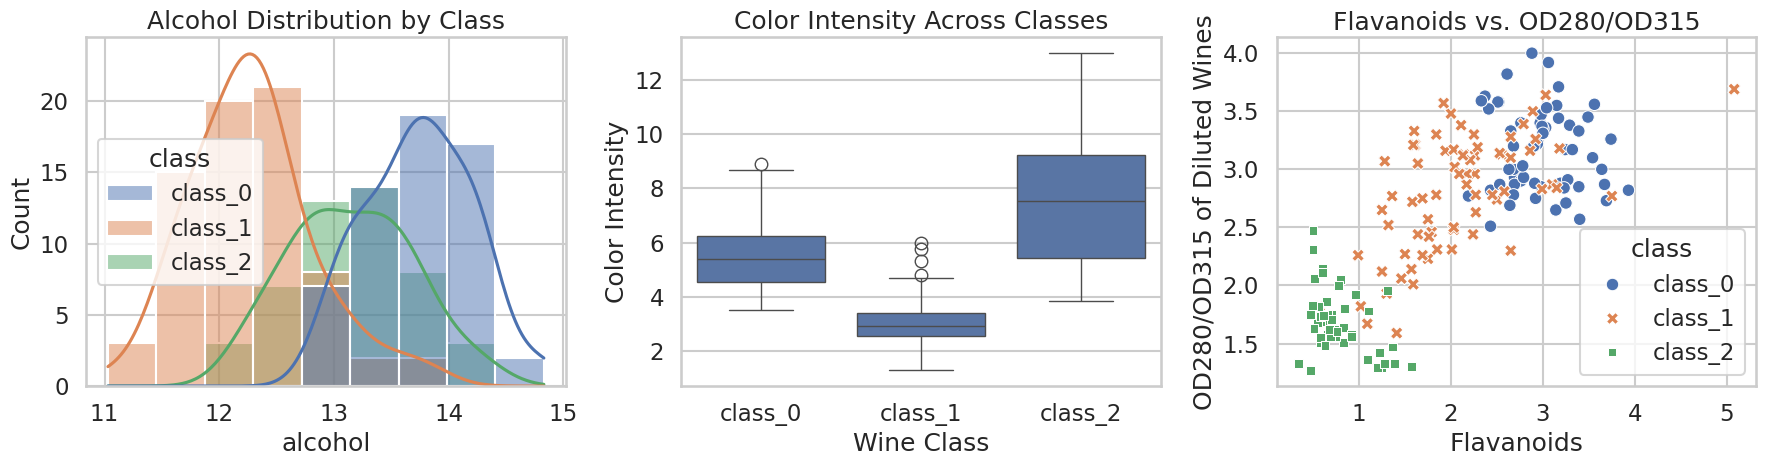

In [15]:
# Separate features and target for downstream modeling
X = df[feature_names]
y = df['target']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# We can plot alcohol content counts and separate hue by class types to see if there is a statistically significant difference.
sns.histplot(data=df, x='alcohol', hue='class', kde=True, ax=axes[0])
axes[0].set_title('Alcohol Distribution by Class')

#We can also separate class and map color intensity as well
sns.boxplot(data=df, x='class', y='color_intensity', ax=axes[1])
axes[1].set_title('Color Intensity Across Classes')
axes[1].set_xlabel('Wine Class')
axes[1].set_ylabel('Color Intensity')

#Finally we can use the flavanoids dimension and graph the flavonoids vs the OD280/315 of the wines since these vlaues are chemcally related so we can see if there is a class difference in that sense.
sns.scatterplot(data=df, x='flavanoids', y='od280_od315_of_diluted_wines', hue='class', style='class', ax=axes[2])
axes[2].set_title('Flavanoids vs. OD280/OD315')
axes[2].set_xlabel('Flavanoids')
axes[2].set_ylabel('OD280/OD315 of Diluted Wines')

plt.tight_layout()

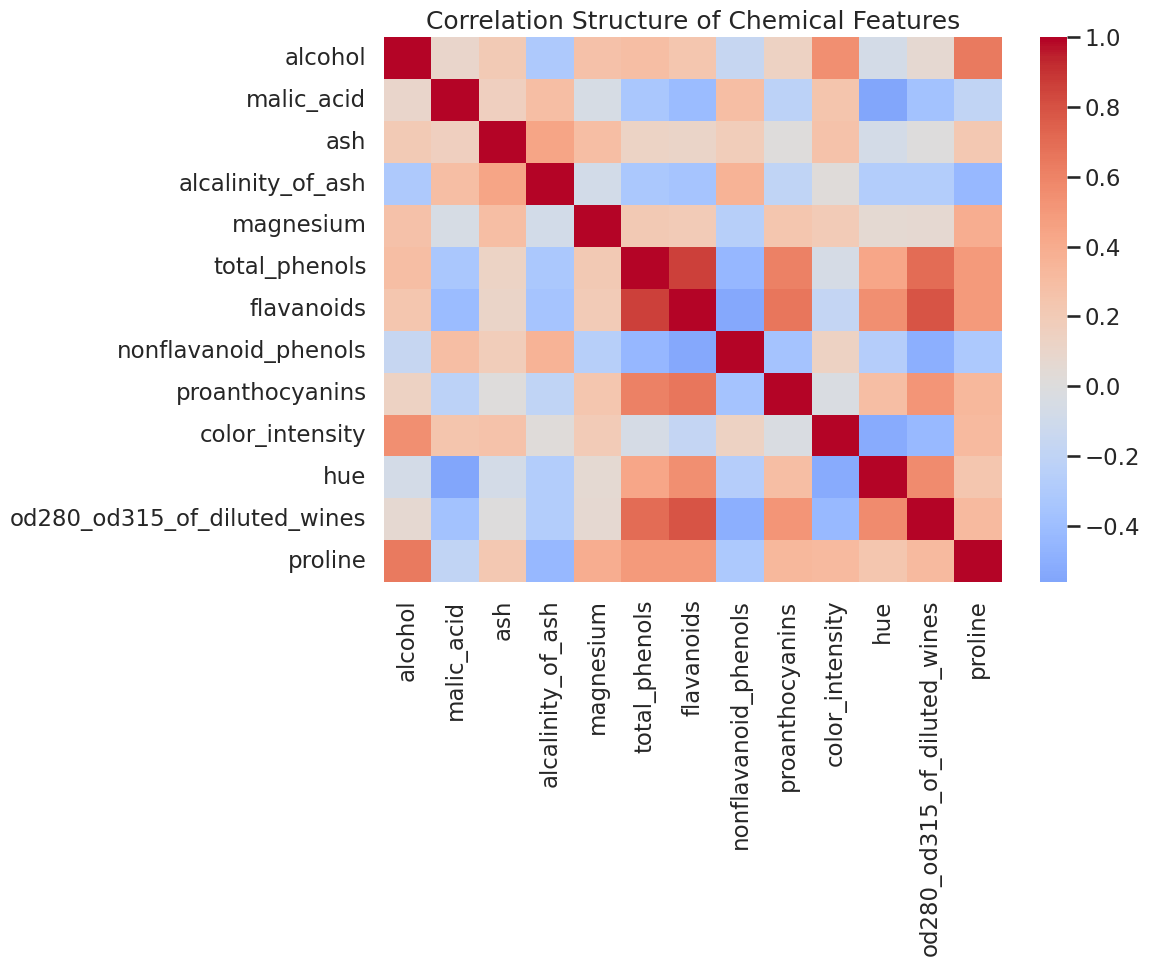

In [18]:
'''We can also make a correlation heat map so that we can broaden the genrazlization and see what aspects of correlation
are actualyl worth exploring instead of makign a detailed chart for every possible combo and wasting computational resources'''
plt.figure(figsize=(12, 10))
correlation_matrix = df[feature_names].corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Structure of Chemical Features')
plt.tight_layout()

Now that we have the pairwise view from the correlational view it must be noted that this only reveals the paiirwise linear relationships between the independent variables. It makes sense to extend the exploration with PCA and pairplots so that we can understand the overall multivariate dataset structure.

The PCA projection doen vbelow reduces the 13 correlational chemical features into two orthogonal components so that we can capture where the largest source of variability exists in the data. When we then plot the data in this 2-D PCA space this allows us to visually assess if wines of different classes cluster separately when all the features are used jointly for prediction. This helps overcome the big weakness of the correlational map where we cannot show the outcome when mutliple variables are considered simulataneously.

It helps us show the maximum combiend variability and says which ddirections explain the variation in the 13 diensional space,

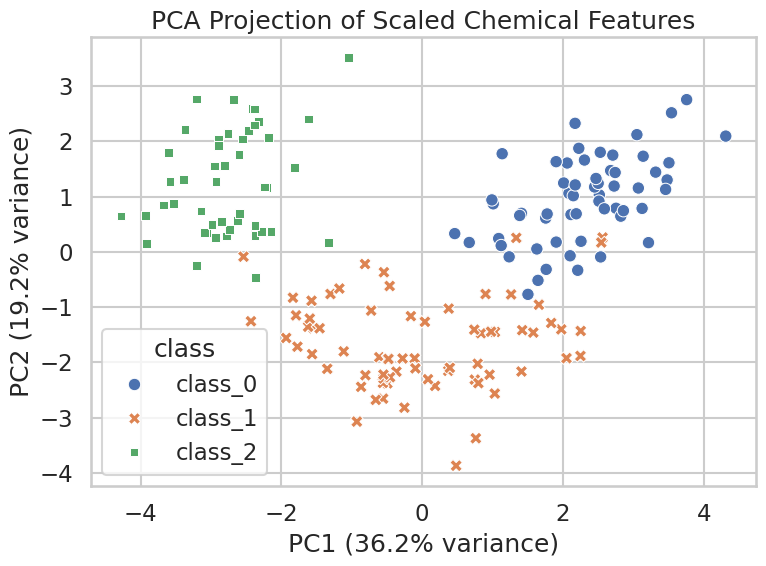

In [20]:
# Principal component projection to summarize multi-feature variation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
components = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(components, columns=['PC1', 'PC2'])
pca_df['class'] = df['class']
pca_df['target'] = df['target']
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='class', style='class', s=80, ax=ax)
ax.set_title('PCA Projection of Scaled Chemical Features')
variance = pca.explained_variance_ratio_
ax.set_xlabel(f'PC1 ({variance[0]:.1%} variance)')
ax.set_ylabel(f'PC2 ({variance[1]:.1%} variance)')
plt.tight_layout()

To better explain think like this:
Before PCA each wine in the list is a pont in 13-dimensional space representing all the previous attributes and so when we condense with PCA to create this linear combinations of the original chemical features we see what directions in that space cause the maximum variation and so see the multivariate data structure.

Sicne we can see that the classes can indeed be separated/isolated in the PCA space meaningfully, furtehr analysis is warranted

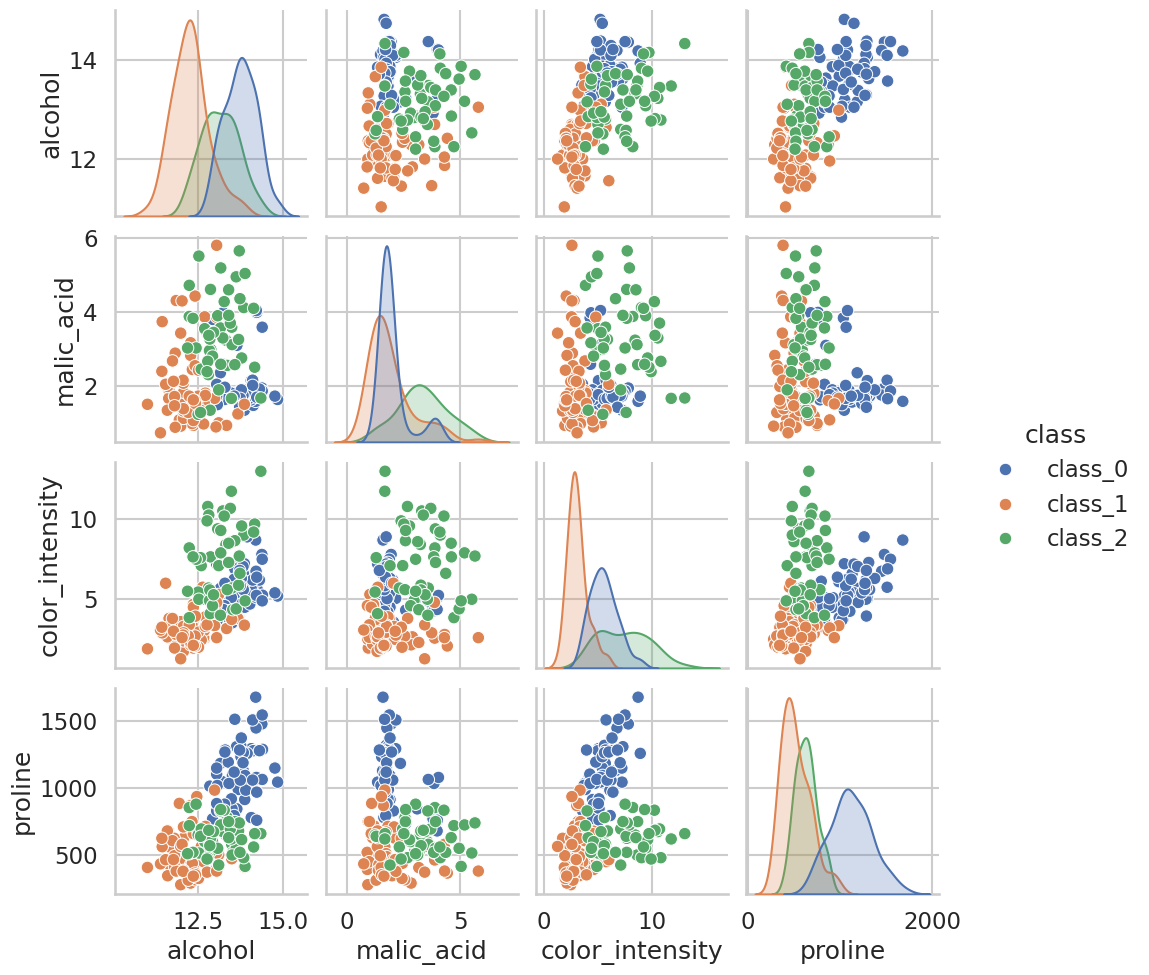

In [22]:
# Pairplot of selected informative features
selected_features = ['alcohol', 'malic_acid', 'color_intensity', 'proline', 'class'];
sns.pairplot(df[selected_features], hue='class', diag_kind='kde');

#5) Classification Models

When we did the PCA we were able to see if teh classifications naturally separated in feature space but it does not test the predictability. So now that we see multivariate structure we naturally want to ask if this structure is strong enough to be learned and can predict for new "unseen" smaples and so influences our classification prediction algorithms

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y);

log_reg_pipeline = Pipeline(
    steps=[('scaler', StandardScaler()),
           ('model', LogisticRegression(max_iter=1000, multi_class='multinomial'))]
);

cv_scores = cross_val_score(log_reg_pipeline, X_train, y_train, cv=5, scoring='accuracy');
print(f"Logistic Regression CV Accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}");

log_reg_pipeline.fit(X_train, y_train);
y_pred_lr = log_reg_pipeline.predict(X_test);
print("Hold-out Classification Report (Logistic Regression):");
print(classification_report(y_test, y_pred_lr, target_names=wine.target_names));

Logistic Regression CV Accuracy: 0.993 ± 0.014
Hold-out Classification Report (Logistic Regression):
              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        12
     class_1       0.93      1.00      0.97        14
     class_2       1.00      0.90      0.95        10

    accuracy                           0.97        36
   macro avg       0.98      0.97      0.97        36
weighted avg       0.97      0.97      0.97        36



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

In [87]:
# Translate logistic regression coefficients into an interpretable table
coef_table = pd.DataFrame(
    log_reg_pipeline.named_steps['model'].coef_,
    columns=feature_names,
    index=[f'class_{i}' for i in range(len(wine.target_names))]
)
coef_table.T.sort_values(by='class_0', ascending=False).head(10)

,class_0,class_1,class_2
proline,0.926539,-1.009905,0.083366
alcohol,0.717483,-0.861536,0.144053
flavanoids,0.705264,0.198202,-0.903466
od280_od315_of_diluted_wines,0.700187,-0.131291,-0.568896
ash,0.460126,-0.807256,0.347130
total_phenols,0.226480,0.062098,-0.288579
color_intensity,0.220184,-1.096016,0.875831
malic_acid,0.167605,-0.512162,0.344557
proanthocyanins,0.125404,0.370369,-0.495773
hue,0.075344,0.630272,-0.705615


Now that we have made thsi classification mdoel we want to see if the relationship is nonlinear and if amore flexible model can still rpoduce a strong performae while allowing us the rpivilege of adaptability.

Logistic regression assumes that the classes are spearated by linear boundaries in feature space and that the effect of teh features is additive. This next step we do is really for unearthing nonlinear relationships betyween fdetaures because for some classes we got perfect f1-scores and numbers that can't quite be improved upon. But still, extending how the relationship applies is still useful.

But with Random Forest Modeling we can see if we can model a non-linear relationship and capture such interactions between features

In [26]:
rf_model = RandomForestClassifier(n_estimators=300, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Hold-out Accuracy: {:.3f}".format((y_pred_rf == y_test).mean()))

Random Forest Hold-out Accuracy: 1.000


Now we can do model evaluation with confusion matrices

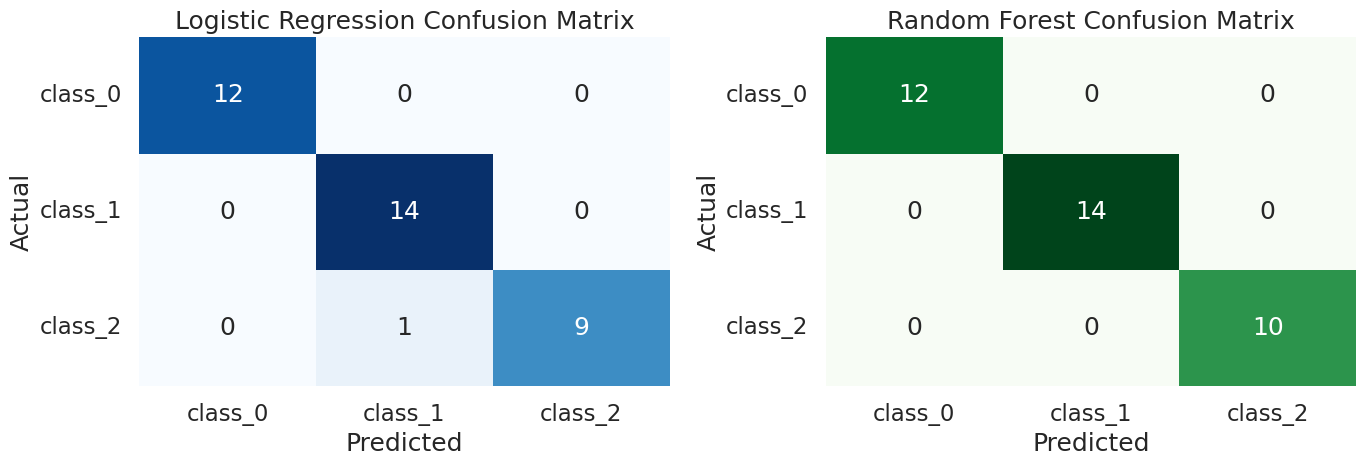

In [88]:
# Confusion matrices for both models
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
axes[0].set_title('Logistic Regression Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_xticklabels(wine.target_names)
axes[0].set_yticklabels(wine.target_names, rotation=0)

cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[1], cbar=False)
axes[1].set_title('Random Forest Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_xticklabels(wine.target_names)
axes[1].set_yticklabels(wine.target_names, rotation=0)

plt.tight_layout()

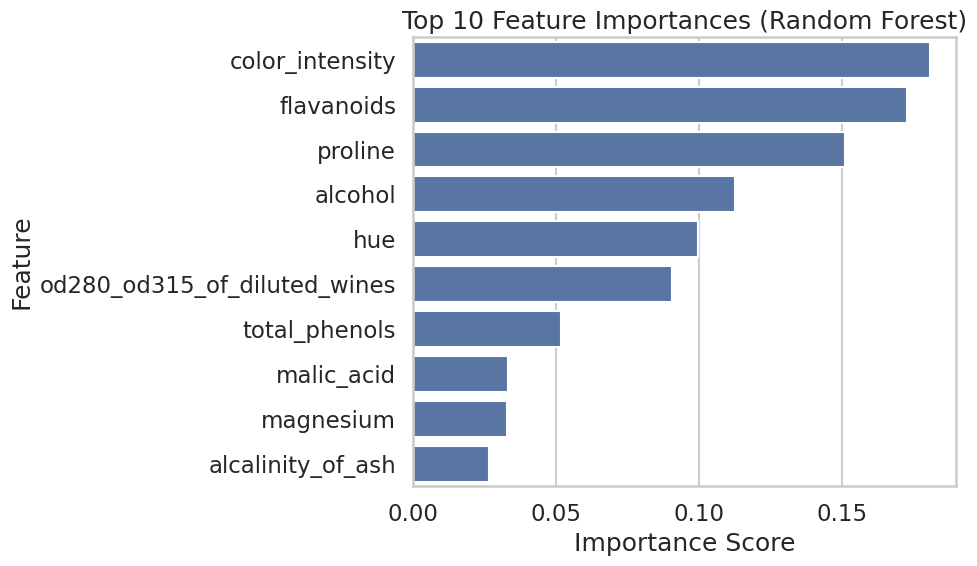

In [89]:
# Feature importance from random forest
importances = pd.Series(rf_model.feature_importances_, index=feature_names).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values[:10], y=importances.index[:10])
plt.title('Top 10 Feature Importances (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()

Now that we have completed a thorough data anaylsis to see what are the most influential factors in predicting wine class we can furtehr explore the fulls tory in the report. Hopefully, seeing these metrics doesn't accidentally turn me to the dark side of becoming a sommelier. Or am I already one...